In [3]:
## set those accordingly
datadir = 'C:/Users/Brandon/jupyter notebooks/DS 8014/GraphMiningNotebooks-master/GraphMiningNotebooks-master/Datasets/'
abcd_path = 'C:/Users/Brandon/.julia/packages/ABCDGraphGenerator/aMeu6/utils/'

In [4]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
import time
from sklearn.metrics import adjusted_mutual_info_score as AMI

## we used those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']

# Question 1

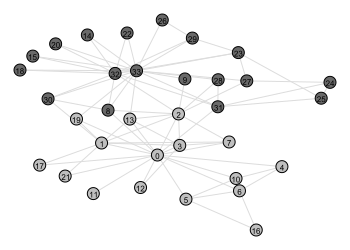

In [5]:
z = ig.Graph.Famous('zachary')
z.vs['size'] = 12
z.vs['name'] = [str(i) for i in range(z.vcount())]
z.vs['label'] = [str(i) for i in range(z.vcount())]
z.vs['label_size'] = 8
z.es['color'] = cls_edges
z.vs['comm'] = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
z.vs['color'] = [cls[i] for i in z.vs['comm']]
#ig.plot(z, 'zachary_gt.eps', bbox=(0,0,300,200))
ig.plot(z, bbox=(0,0,350,250))

In [6]:
ground_truth = z.vs['comm']
Scores = []

In [7]:
# applying ECG algorithm on Karate club graph
ecg = z.community_ecg().membership
AMI_ecg = AMI(ecg, ground_truth)
print(AMI_ecg)
Scores.append(["ECG", AMI_ecg])

0.5653497612707895


In [8]:
# applying Louvain algorithm
Louvain = z.community_multilevel().membership
AMI_Louvain = AMI(Louvain, ground_truth)
print(AMI_Louvain)
Scores.append(["Louvain", AMI_Louvain])

0.5805154226518419


In [9]:
# applying InfoMap algorithm
InfoMap = z.community_infomap().membership
AMI_InfoMap = AMI(InfoMap, ground_truth)
print(AMI_InfoMap)
Scores.append(["Infomap", AMI_InfoMap])

0.6874223479049212


In [10]:
# applying Label Propagation algorithm
Lpl = z.community_label_propagation().membership
AMI_Lpl = AMI(Lpl, ground_truth)
print(AMI_Lpl)
Scores.append(["Label Propagation", AMI_Lpl])

0.20149072779609306


In [11]:
# applying Girvan-Newman algorithm
GirNew = z.community_edge_betweenness().as_clustering().membership
AMI_GirNew = AMI(GirNew, ground_truth)
print(AMI_GirNew)
Scores.append(["Girvan-Newman", AMI_GirNew])

0.5499173029289166


In [12]:
# applying CNM algorithm
cnm = z.community_fastgreedy().as_clustering().membership
AMI_cnm = AMI(cnm, ground_truth)
print(AMI_cnm)
Scores.append(["CNM", AMI_cnm])

0.6807645098886008


In [14]:
Scores
D = pd.DataFrame(Scores, columns = ["Algorithm", "AMI Score"])
D

,Algorithm,AMI Score
0,ECG,0.565350
1,Louvain,0.580515
2,Infomap,0.687422
3,Label Propagation,0.201491
4,Girvan-Newman,0.549917
5,CNM,0.680765


In the above table we can see that the Label Propagation AMI score:0.833466 is the highest suggesting that it identifies the community structure almost similiar to the ground truth.

# Question 2

In [16]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv('musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv('musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
gh.es['color'] = 'grey' ## edge color

## there are 2 node types: ml or web
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount())

GitHub nodes: 37700 ; ml developers: 9739


In [17]:
# applying all the algorithms on Github ml graph
ecg_ml = gh_ml.community_ecg().membership

In [18]:
Louvain_ml = gh_ml.community_multilevel().membership

In [19]:
InfoMap_ml = gh_ml.community_infomap().membership

In [20]:
Lpl_ml = gh_ml.community_label_propagation().membership

In [ ]:
#GirNew_ml = gh_ml.community_edge_betweenness().as_clustering().membership
# GN takes >1 day to run!

In [21]:
cnm_ml = gh_ml.community_fastgreedy().as_clustering().membership

In [22]:
# Finding pair wise AMI Score for all the algorithms
Scores_pairs = []
Scores_pairs.append(["ECG", "Louvain", AMI(ecg_ml, Louvain_ml)])
Scores_pairs.append(["ECG", "InfoMap", AMI(ecg_ml, InfoMap_ml)])
Scores_pairs.append(["ECG", "Label Propagation", AMI(ecg_ml, Lpl_ml)])
#Scores_pairs.append(["ECG", "Girvan-Newman", AMI(ecg_ml, GirNew_ml)])
Scores_pairs.append(["ECG", "CNM", AMI(ecg_ml, cnm_ml)])
Scores_pairs.append(["Louvain", "InfoMap", AMI(Louvain_ml, InfoMap_ml)])
Scores_pairs.append(["Louvain", "Label Propagation", AMI(Louvain_ml, Lpl_ml)])
#Scores_pairs.append(["Louvain", "Girvan-Newman", AMI(Louvain_ml, GirNew_ml)])
Scores_pairs.append(["Louvain", "CNM", AMI(Louvain_ml, cnm_ml)])
Scores_pairs.append(["InfoMap", "Label Propagation", AMI(InfoMap_ml, Lpl_ml)])
#Scores_pairs.append(["InfoMap", "Girvan-Newman", AMI(InfoMap_ml, GirNew_ml)])
Scores_pairs.append(["InfoMap", "CNM", AMI(InfoMap_ml, cnm_ml)])
#Scores_pairs.append(["Label Propagation", "Girvan-Newman", AMI(Lpl_ml, GirNew_ml)])
Scores_pairs.append(["Label Propagation", "CNM", AMI(Lpl_ml, cnm_ml)])
#Scores_pairs.append(["Girvan-Newman", "CNM", AMI(GirNew_ml, cnm_ml)])

In [23]:
D2 = pd.DataFrame(Scores_pairs, columns = ["Algorithm1", "Algorithm2", "AMI Score"])
D2

,Algorithm1,Algorithm2,AMI Score
0,ECG,Louvain,0.629947
1,ECG,InfoMap,0.568062
2,ECG,Label Propagation,0.488016
3,ECG,CNM,0.536424
4,Louvain,InfoMap,0.499681
5,Louvain,Label Propagation,0.572733
6,Louvain,CNM,0.576453
7,InfoMap,Label Propagation,0.285687
8,InfoMap,CNM,0.466473
9,Label Propagation,CNM,0.588858


The AMI score for the algorithm pairs of:
ECG-Louvain,
ECG-InforMap,
ECG-CNM,
Louvain-Label Propagation,
Louvain-CNM, 
Label Propagation-CNM returned similar results with an AMI score of greater than 0.5.

## Question 5

In [3]:
## read graph and communities; plot
g = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_1000_comms.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1]-1 for x in g.vs]
gt = {k:(v-1) for k,v in enumerate(g.vs['comm'])}
## map between int(name) to key
n2k = {int(v):k for k,v in enumerate(g.vs['name'])}
g.vs['size'] = 3
##g.es['color'] = cls_edges
##g.vs['color'] = [cls[i] for i in g.vs['comm']]
##ig.plot(g, bbox=(0,0,300,200))

In [4]:
## compute internal degrees
in_deg_0 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==0 and g.vs['comm'][e.tuple[1]]==0],
                            delete_vertices=False).degree()
in_deg_1 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==1 and g.vs['comm'][e.tuple[1]]==1],
                            delete_vertices=False).degree()
in_deg_2 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==2 and g.vs['comm'][e.tuple[1]]==2],
                            delete_vertices=False).degree()
in_deg_3 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==3 and g.vs['comm'][e.tuple[1]]==3],
                            delete_vertices=False).degree()
in_deg_4 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==4 and g.vs['comm'][e.tuple[1]]==4],
                            delete_vertices=False).degree()
in_deg_5 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==5 and g.vs['comm'][e.tuple[1]]==5],
                            delete_vertices=False).degree()
in_deg_6 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==6 and g.vs['comm'][e.tuple[1]]==6],
                            delete_vertices=False).degree()
in_deg_7 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==7 and g.vs['comm'][e.tuple[1]]==7],
                            delete_vertices=False).degree()
in_deg_8 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==8 and g.vs['comm'][e.tuple[1]]==8],
                            delete_vertices=False).degree()
in_deg_9 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==9 and g.vs['comm'][e.tuple[1]]==9],
                            delete_vertices=False).degree()
in_deg_10 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==10 and g.vs['comm'][e.tuple[1]]==10],
                            delete_vertices=False).degree()
in_deg_11 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==11 and g.vs['comm'][e.tuple[1]]==11],
                            delete_vertices=False).degree()



## compute z (normalized within-module degree)
g.vs['in_deg'] = [in_deg_0[i] + in_deg_1[i] + in_deg_2[i] + in_deg_3[i] + in_deg_4[i] + in_deg_5[i] + in_deg_6[i] + in_deg_7[i] + in_deg_8[i]+ in_deg_9[i] + in_deg_10[i] + in_deg_11[i] for i in range(g.vcount())]
mu = [np.mean([x for x in in_deg_0 if x>0]),np.mean([x for x in in_deg_1 if x>0]),np.mean([x for x in in_deg_2 if x>0]),np.mean([x for x in in_deg_3 if x>0]),np.mean([x for x in in_deg_4 if x>0]),np.mean([x for x in in_deg_5 if x>0]),np.mean([x for x in in_deg_6 if x>0]),np.mean([x for x in in_deg_7 if x>0]),np.mean([x for x in in_deg_8 if x>0]),np.mean([x for x in in_deg_9 if x>0]),np.mean([x for x in in_deg_10 if x>0]),np.mean([x for x in in_deg_11 if x>0])]
sig = [np.std([x for x in in_deg_0 if x>0],ddof=1),np.std([x for x in in_deg_1 if x>0],ddof=1),np.std([x for x in in_deg_2 if x>0],ddof=1),np.std([x for x in in_deg_3 if x>0],ddof=1),np.std([x for x in in_deg_4 if x>0],ddof=1),np.std([x for x in in_deg_5 if x>0],ddof=1),np.std([x for x in in_deg_6 if x>0],ddof=1),np.std([x for x in in_deg_7 if x>0],ddof=1),np.std([x for x in in_deg_8 if x>0],ddof=1),np.std([x for x in in_deg_9 if x>0],ddof=1),np.std([x for x in in_deg_10 if x>0],ddof=1),np.std([x for x in in_deg_11 if x>0],ddof=1)]
g.vs['z'] = [(v['in_deg']-mu[v['comm']])/sig[v['comm']] for v in g.vs]

## computing p (participation coefficient)
g.vs['deg'] = g.degree()
g.vs['out_deg'] = [v['deg'] - v['in_deg'] for v in g.vs]
g.vs['p'] = [1-(v['in_deg']/v['deg'])**2-(v['out_deg']/v['deg'])**2 for v in g.vs]
D = pd.DataFrame(np.array([g.vs['z'],g.vs['p']]).transpose(),columns=['z','p']).sort_values(by='z',ascending=False)
D.head()

,z,p
61,5.738789,0.497449
74,5.339659,0.499260
176,4.938409,0.484757
206,4.806462,0.495465
95,4.678961,0.491493


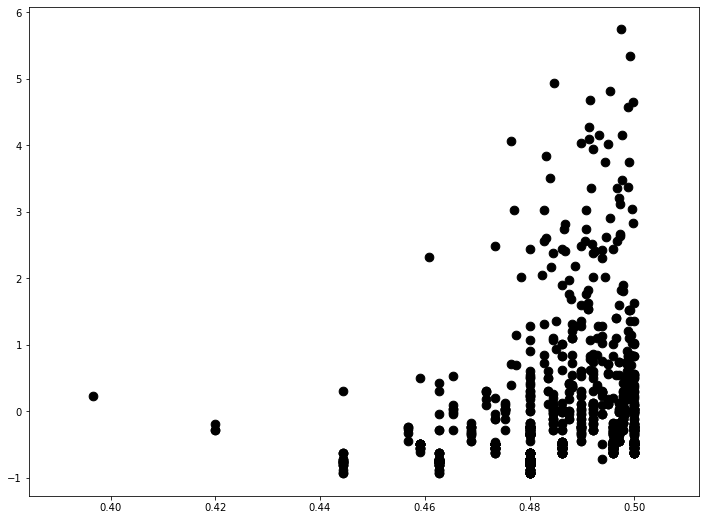

In [5]:
## Figure 5.3(b) -- comparing the roles
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(g.vs['p'],g.vs['z'],marker='o',s=75, color='k')

#plt.plot([0, .5], [2.5, 2.5], color='k', linestyle='-', linewidth=2)
#plt.plot([.05, .05], [-.5, 2.4], color='k', linestyle='-', linewidth=2)

In [6]:
ultra_peri = len(D[(D['z'] <= 2.5) & (D['p'] < 0.05)])
peri = len(D[(D['z'] <= 2.5) & (D['p'] >= 0.05) & (D.p<0.62)])
connector_nonhub = len(D[(D['z'] <= 2.5) & (D['p'] >= 0.62) & (D['p']<0.80)])
kinless_non_hub = len(D[(D['z'] <= 2.5) & (D['p'] >= 0.8)])

provincial = len(D[(D['z'] > 2.5) & (D['p'] < 0.3)])
connector_hub = len(D[(D['z'] > 2.5) & (D['p'] >= 0.3) & (D['p']<0.75)])
kinless_hub = len(D[(D['z'] > 2.5) & (D['p'] >= 0.75)])

print("Non-Hubs:")
print("There are ", ultra_peri, "ultra-peripheral nodes")
print("There are ", peri, "peripheral nodes")
print("There are ", connector_nonhub, "connector nodes")
print("There are ", kinless_non_hub, "kinless nodes")

print("Hubs:")
print("There are ", provincial, "provincial hubs")
print("There are ", connector_hub, "connector hubs")
print("There are ", kinless_hub, "kinless hubs")

Non-Hubs:
There are  0 ultra-peripheral nodes
There are  958 peripheral nodes
There are  0 connector nodes
There are  0 kinless nodes
Hubs:
There are  0 provincial hubs
There are  42 connector hubs
There are  0 kinless hubs


# Question 6

In [12]:
algos = ['ECG', 'Louvian', 'Infomap', 'Label Propogation', 'GN', 'CNM']
nodes = ['100', '200', '400', '800', '1600']
result = []

for n in nodes:
    times = []
    
    cmd = 'julia '+abcd_path+'abcd_sampler.jl ' +abcd_path+'abcd_'+n+'.toml'
    os.system(cmd)
    g = ig.Graph.Read_Ncol('edge_'+n+'.dat',directed=False)
    
    start_time = time.process_time()
    ec = g.community_ecg().membership
    end_time = time.process_time()
    times.append(end_time - start_time)
    
    start_time = time.process_time()
    ml = g.community_multilevel().membership
    end_time = time.process_time()
    times.append(end_time - start_time)
    
    start_time = time.process_time()
    im = g.community_infomap().membership
    end_time = time.process_time()
    times.append(end_time - start_time)
    
    start_time = time.process_time()
    lp = g.community_label_propagation().membership
    end_time = time.process_time()
    times.append(end_time - start_time)
       
    start_time = time.process_time()
    gn = g.community_edge_betweenness()
    end_time = time.process_time()
    times.append(end_time - start_time)
    
    start_time = time.process_time()
    cnm = g.community_fastgreedy().as_clustering().membership
    end_time = time.process_time()
    times.append(end_time - start_time)
    
    result.append(times)
    



In [13]:
df = pd.DataFrame(result, index=nodes, columns = algos)
print(df)

           ECG  Louvian   Infomap  Label Propogation          GN       CNM
100   0.000000      0.0  0.000000           0.000000    0.000000  0.000000
200   0.015625      0.0  0.000000           0.000000    0.000000  0.000000
400   0.015625      0.0  0.015625           0.000000    0.015625  0.000000
800   0.031250      0.0  0.031250           0.000000    0.125000  0.000000
1600  0.343750      0.0  1.187500           0.015625  340.656250  0.046875


Label propogation takes the shortest time, with it only taking up 0.01 seconds at 1600 nodes, whereaas Girvan-Newman takes the longest time, at 340 seconds for 1600 nodes (perhaps due to , and took higher than all other algorithms at 400 and 800 nodes.